# CDFS SWIRE master catalogue
## Preparation of COMBO data

Classifying Objects by Medium-Band Observations - a spectrophotometric 17-filter survey (COMBO-17). COMBO catalogue: the catalogue comes from `dmu0_COMBO-17`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The total magnitude (aperture magnitudes are not provided.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
a03d5b3 (Wed Jul 5 12:19:29 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "combo_ra"
DEC_COL = "combo_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
    'Seq':'combo_id', 
    'ra':'combo_ra', 
    'dec':'combo_dec',  
    'stellarity':'combo_stellarity',
    'Rmag':'m_combo_r',    
    'e_Rmag':'merr_combo_r',  
    'UjMag':'m_combo_uj',   
    'e_UjMag':'merr_combo_uj', 
    'BjMag':'m_combo_bj',   
    'e_BjMag':'merr_combo_bj',
    'VjMag':'m_combo_vj',   
    'e_VjMag':'merr_combo_vj',
    'usMag':'m_combo_us',   
    'e_usMag':'merr_combo_us',
    'gsMag':'m_combo_gs',   
    'e_gsMag':'merr_combo_gs',
    'rsMag':'m_combo_rs',   
    'e_rsMag':'merr_combo_rs',
    'UbMag':'m_combo_ub',   
    'e_UbMag':'merr_combo_ub',
    'BbMag':'m_combo_bb',   
    'e_BbMag':'merr_combo_bb',
    'VbMag':'m_combo_vb',   
    'e_VbMag':'merr_combo_vb',
    'S280Mag':'m_combo_s280', 
    'e_S280Mag':'merr_combo_s280',
    'S145Mag':'m_combo_s145', 
    'e_S145Mag':'merr_combo_s145'
    })


catalogue = Table.read("../../dmu0/dmu0_COMBO-17/data/table3.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2009 #table says e.g. 55962.33945

# Clean table metadata
catalogue.meta = None

In [5]:
#Replace 0.0 with NaN values
for col in catalogue.colnames:
    if col.startswith('m'): # | col.endswith('ra') | col.endswith('dec'):
        catalogue[col][np.where(catalogue[col] == 0.0)] = np.nan

# Add flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))

        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        #We add NAN filled aperture columns because no aperture fluxes are present
        nancol = np.zeros(len(catalogue))
        nancol.fill(np.nan)
        catalogue.add_column(Column(nancol, 
                                    name="m_ap{}".format(col[1:])))
        catalogue.add_column(Column(nancol, 
                                    name="merr_ap{}".format(col[1:])))
        catalogue.add_column(Column(nancol, 
                                    name="f_ap{}".format(col[1:])))
        catalogue.add_column(Column(nancol, 
                                    name="ferr_ap{}".format(col[1:])))
        
        # 
        
        # Band-flag column
        catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [7]:
catalogue[:10].show_in_notebook()

idx,combo_id,combo_ra,combo_dec,combo_stellarity,m_combo_r,merr_combo_r,m_combo_uj,merr_combo_uj,m_combo_bj,merr_combo_bj,m_combo_vj,merr_combo_vj,m_combo_us,merr_combo_us,m_combo_gs,merr_combo_gs,m_combo_rs,merr_combo_rs,m_combo_ub,merr_combo_ub,m_combo_bb,merr_combo_bb,m_combo_vb,merr_combo_vb,m_combo_s280,merr_combo_s280,m_combo_s145,merr_combo_s145,f_combo_r,ferr_combo_r,m_ap_combo_r,merr_ap_combo_r,f_ap_combo_r,ferr_ap_combo_r,flag_combo_r,f_combo_uj,ferr_combo_uj,m_ap_combo_uj,merr_ap_combo_uj,f_ap_combo_uj,ferr_ap_combo_uj,flag_combo_uj,f_combo_bj,ferr_combo_bj,m_ap_combo_bj,merr_ap_combo_bj,f_ap_combo_bj,ferr_ap_combo_bj,flag_combo_bj,f_combo_vj,ferr_combo_vj,m_ap_combo_vj,merr_ap_combo_vj,f_ap_combo_vj,ferr_ap_combo_vj,flag_combo_vj,f_combo_us,ferr_combo_us,m_ap_combo_us,merr_ap_combo_us,f_ap_combo_us,ferr_ap_combo_us,flag_combo_us,f_combo_gs,ferr_combo_gs,m_ap_combo_gs,merr_ap_combo_gs,f_ap_combo_gs,ferr_ap_combo_gs,flag_combo_gs,f_combo_rs,ferr_combo_rs,m_ap_combo_rs,merr_ap_combo_rs,f_ap_combo_rs,ferr_ap_combo_rs,flag_combo_rs,f_combo_ub,ferr_combo_ub,m_ap_combo_ub,merr_ap_combo_ub,f_ap_combo_ub,ferr_ap_combo_ub,flag_combo_ub,f_combo_bb,ferr_combo_bb,m_ap_combo_bb,merr_ap_combo_bb,f_ap_combo_bb,ferr_ap_combo_bb,flag_combo_bb,f_combo_vb,ferr_combo_vb,m_ap_combo_vb,merr_ap_combo_vb,f_ap_combo_vb,ferr_ap_combo_vb,flag_combo_vb,f_combo_s280,ferr_combo_s280,m_ap_combo_s280,merr_ap_combo_s280,f_ap_combo_s280,ferr_ap_combo_s280,flag_combo_s280,f_combo_s145,ferr_combo_s145,m_ap_combo_s145,merr_ap_combo_s145,f_ap_combo_s145,ferr_ap_combo_s145,flag_combo_s145
,,,,,mag,mag,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,mag @H0=100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7864,52.9043509407,-28.004407161,0.704,25.9685,0.2545,-16.8335858104,0.289280533791,-16.1213024315,0.939844787121,-16.41656581,0.939844787121,-16.9804966689,0.289280533791,-16.2014578601,0.939844787121,-16.6361515477,0.939844787121,nan,nan,nan,nan,nan,nan,-16.8034956128,0.609699368477,nan,nan,0.148806,0.0348805,nan,nan,nan,nan,False,1.96532475335e+16,5.23635659592e+15,nan,nan,nan,nan,False,1.01981400693e+16,8.82780618392e+15,nan,nan,nan,nan,False,1.33852449747e+16,1.15866567392e+16,nan,nan,nan,nan,False,2.25008366885e+16,5.99506032816e+15,nan,nan,nan,nan,False,1.09795146886e+16,9.50418674442e+15,nan,nan,nan,nan,False,1.63855347398e+16,1.41837946841e+16,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,1.91160538442e+16,1.07346940311e+16,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
1,7867,52.9248830635,-28.0045354786,0.659,25.7862,0.2353,-17.6367689613,0.273388147354,-17.4349329199,0.523457169533,-17.798817823,0.523457169533,-17.7750868334,0.273388147354,-17.5348377222,0.523457169533,-18.0605224591,0.523457169533,nan,nan,nan,nan,nan,nan,-18.2183962955,0.354991674423,nan,nan,0.175997,0.038142,nan,nan,nan,nan,False,4.11820142481e+16,1.03696225015e+16,nan,nan,nan,nan,False,3.41958314623e+16,1.64865582161e+16,nan,nan,nan,nan,False,4.7810923141e+16,2.30506916786e+16,nan,nan,nan,nan,False,4.67772550611e+16,1.17785029581e+16,nan,nan,nan,nan,False,3.74916961709e+16,1.80755666732e+16,nan,nan,nan,nan,False,6.08427707855e+16,2.93336304365e+16,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,7.03652958866e+16,2.3006595984e+16,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False
2,7868,52.8874689235,-28.0044207329,0.15,25.622,0.2452,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.20473,0.0462358,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,nan,nan

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['merr_combo_r',  
     'merr_combo_uj', 
     'merr_combo_bj',
     'merr_combo_vj',
     'merr_combo_us',
     'merr_combo_gs',
     'merr_combo_rs',
     'merr_combo_ub',
     'merr_combo_bb',
     'merr_combo_vb',
     'merr_combo_s280',
     'merr_combo_s145']
FLAG_NAME = 'combo_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 55551 sources.
The cleaned catalogue has 55551 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_CDFS-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

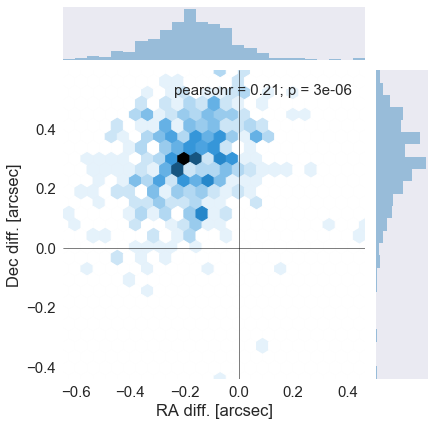

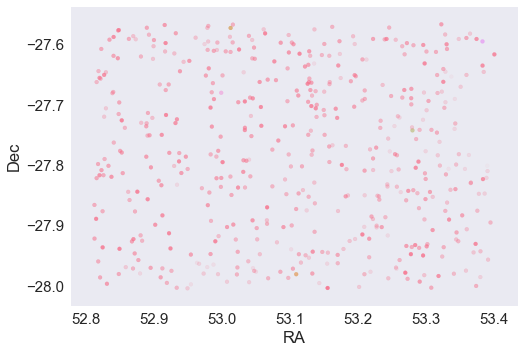

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.17176691378040232 arcsec
Dec correction: -0.2955689068215861 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

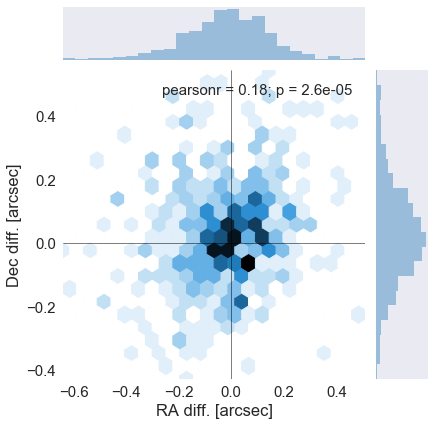

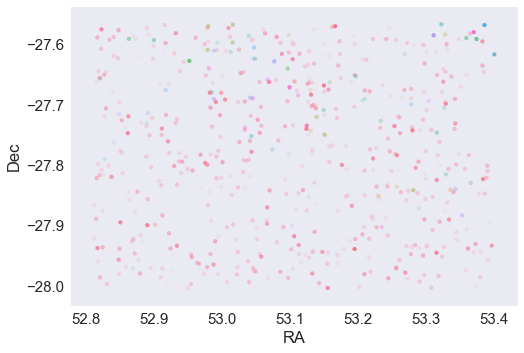

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "combo_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

566 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/COMBO.fits".format(OUT_DIR), overwrite=True)